In [1]:
pip install --upgrade pip

     ---------------------------------------- 2.1/2.1 MB 2.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install segyio

In [3]:
import numpy as np
import segyio
import matplotlib.pyplot as plt
from scipy import signal
from math import sqrt, pi
from shutil import copyfile

In [4]:
# Загружаем куб акустического импеданса 
# (который можно получить умножив куб скорости на куб плотности).
# Обращаем внимание, что перевод формата в segy был произведён в Petrel.
# Основная сложность применения этого кода для OilCase - переход в формат segy в Пайтоне.

# * segy - это общепринятый формат сейсмических данных, в котором много параметров,
# но главные для нас здесь - координаты, глубина (время) и значение амплитуды в каждой точке.

In [5]:
ai_cube = segyio.tools.cube('F:/Share/OilCase/AI_3channels.sgy') # загрузка куба

In [6]:
# Разрез по кросслайну 25
# Это пока просто импеданс, палетка обыкновенная геологическая
# Здесь смотрим на адекватность исходных данных

# В данном случае - sample - это глубина

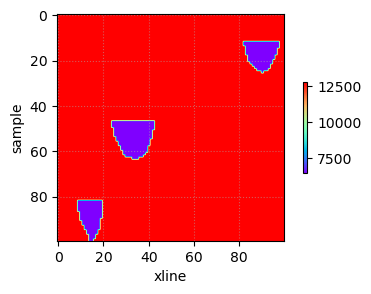

In [7]:
# Разрез
plt.figure(figsize=(5, 3), dpi = 100)
plt.imshow(ai_cube[25,:,:].transpose(), cmap='rainbow') # итоговая синтетическая сейсмика
plt.xlabel('xline')
plt.ylabel('sample')
plt.grid(ls=':',alpha=.5)
plt.colorbar(shrink=0.4)

In [8]:
def make_seis(model, dt, points, sign_freq):
    '''
    Функция выполняет сверточное моделирование на основании входного куба АИ
    model - куб акустичсекой жесткости
    dt - Шаг дискретизации (ms);
    points-  длина вейвлета в дискретах (samples)
    sign_freq - частота вейвлета (Hz)
    '''

    bfreq = 1./dt # Частота дискретизации
    a = bfreq/(sqrt(2.0)*pi*sign_freq) # Масштаб дискрета
    
    rpp = np.zeros((model.shape))
    seis = np.zeros((model.shape))
    
    for i in range(model.shape[0]):
        for j in range(model.shape[1]):
            for k in range(model.shape[2]-1):
                rpp[i,j,k] = (model[i,j,k+1]-model[i,j,k])/(model[i,j,k+1]+model[i,j,k])
                
            seis[i,j,:] = seis[i,j,:] + np.convolve(rpp[i,j,:], signal.ricker(points, a), mode='same')

    return seis

In [9]:
 # Меняем только частоту (Гц) - последний параметр, остальные не трогаем. 
# Шаг дискретизации 0,002 секунды стандартный
# Длина вейвлета 45 дискретов параметр технический, его я могу поварьировать на новой модели,
# но скорее всего не изменится

In [10]:
seismic = make_seis(ai_cube, 0.002, 45, 70)

In [11]:
# Далее уже цветовая шкала сейсмики
# Да, в случае без шума выглядит нереалистично, но полностью соответствует модели

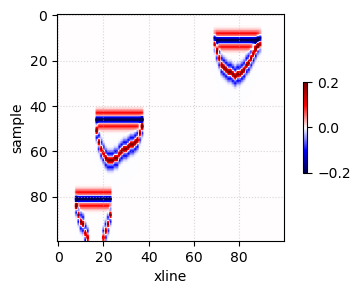

In [12]:
# Разрез
plt.figure(figsize=(5, 3), dpi = 100)
plt.imshow(seismic[-25,:,:].transpose(), vmin = -0.2, vmax = 0.2, cmap='seismic') # итоговая синтетическая сейсмика
plt.xlabel('xline')
plt.ylabel('sample')
plt.grid(ls=':',alpha=.5)
plt.colorbar(shrink=0.4)


In [ ]:
# На горизонтальном срезе видим один из каналов

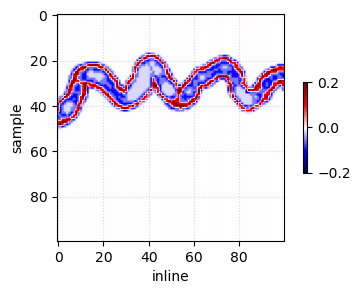

In [13]:
# Разрез или карта (срез)
plt.figure(figsize=(5, 3), dpi = 100)
plt.imshow(seismic[:,:,60].transpose(), vmin = -0.2, vmax = 0.2, cmap='seismic') # итоговая синтетическая сейсмика
plt.xlabel('inline')
plt.ylabel('sample')
plt.grid(ls=':',alpha=.5)
plt.colorbar(shrink=0.4)

In [85]:
# Строки 12-15 ШУМ

In [14]:
def add_noise(cube, dt, points, sign_freq, nlv):
    '''
    функция добавляет случайный шум к входному кубу
    cube - сейсмический куб
    dt - Шаг дискретизации (ms);
    points-  длина вейвлета в дискретах (samples)
    sign_freq - частота вейвлета (Hz)
    nlv - доля шума относительно амплитуды сигнала Риккера
    '''
    bfreq = 1./dt # Частота дискретизации
    a = bfreq/(sqrt(2.0)*pi*sign_freq) # Масштаб дискрета
    
    
    seismic_noise = cube + (np.random.uniform(-1.0, 1.0, size=cube.shape)*signal.ricker(points, a).max()*nlv)
    
    return seismic_noise     

In [15]:
# Пример с уровнем шума 5%
# Предлагаю варьировать шум от 5% для новой сеймики до 30% для старой сейсмики

In [16]:
noise_seis = add_noise(seismic, 0.002, 15, 30, 0.05)

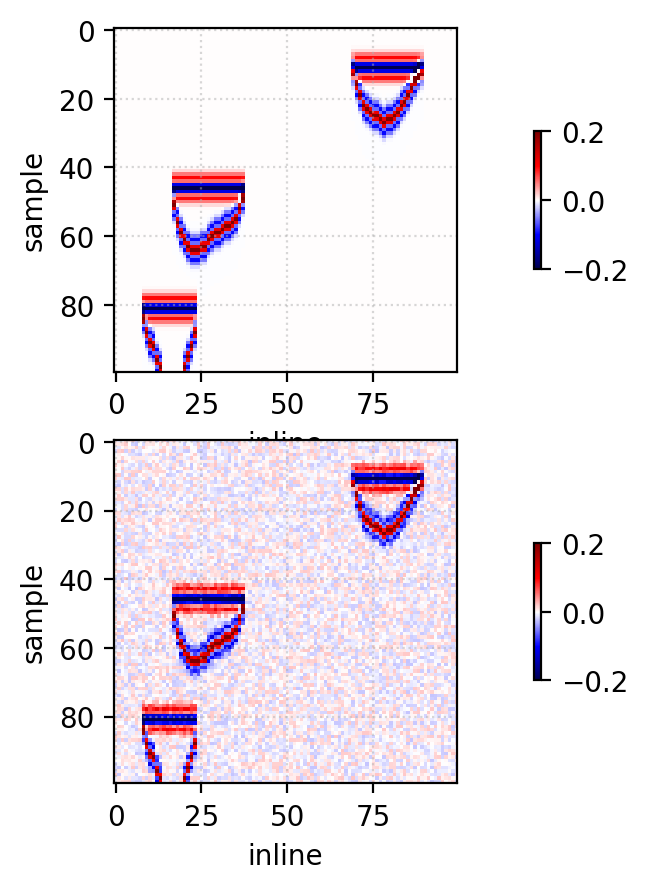

In [17]:
plt.figure(figsize=(10, 5), dpi = 200)
plt.subplot(211)
plt.imshow(seismic[-25,:,:].transpose(), vmin = -0.2, vmax = 0.2, cmap='seismic') # итоговая синтетическая сейсмика
plt.xlabel('inline')
plt.ylabel('sample')
plt.grid(ls=':',alpha=.5)
plt.colorbar(shrink=0.4)
plt.subplot(212)
plt.imshow(noise_seis[-25,:,:].transpose(), vmin = -0.2, vmax = 0.2, cmap='seismic') # итоговая синтетическая сейсмика
plt.xlabel('inline')
plt.ylabel('sample')
plt.grid(ls=':',alpha=.5)
plt.colorbar(shrink=0.4)

In [ ]:
# Думаю, что в нашей ситуации код ниже не нужен
# Оставляю, так как возможно будет проще разобраться с форматом segy
# Если есть необходмость выгрузки результата в стандартном сейсмическом формате
# И загрузки, например в Petrel или другое ПО

In [25]:
# Запись файла SGY

def save_sgy_model(input_file, output_file, cube):
    '''
    Функция записывает файл по существующему шаблону (из которого берется заполнение заголовков)
    input_file - существующий шаблон файла SGY
    output_file - выходной SGY-файл
    cube - записываемый массив
    '''
    copyfile(input_file, output_file)
    with segyio.open(output_file, "r+") as src:
        k = 0
        for i in src.ilines:
            src.iline[i] = cube[k].reshape((cube.shape[1]*cube.shape[2]))
            k += 1

In [ ]:
# Без шума:

In [85]:
input_file = 'F:/.../AI.sgy'
output_file = 'F:/.../f70Hz_noise10.sgy'

save_sgy_model(input_file, output_file, seismic)

C:\ProgramData\Anaconda3\lib\site-packages\segyio\utils.py:23: RuntimeWarning: Implicit conversion from float64 to float32 (narrowing)
  warnings.warn(msg.format(x.dtype, dtype), RuntimeWarning)


In [ ]:
# Для случая с шумом:

In [26]:
input_file = 'F:/.../AI.sgy'
output_file = 'F:/.../f70Hz_noise5.sgy'

save_sgy_model(input_file, output_file, noise_seis)

C:\ProgramData\Anaconda3\lib\site-packages\segyio\utils.py:23: RuntimeWarning: Implicit conversion from float64 to float32 (narrowing)
  warnings.warn(msg.format(x.dtype, dtype), RuntimeWarning)


In [ ]:
# Выгрузка массива
# Это возможно лишнее, но может пригодится

In [110]:
import pandas as pd

In [116]:
dat = []
for i in range (100):
    for j in range(100):
        a = noise_seis[i,j,:]
        dat.append(a)
        a =[]

In [117]:
clust_data = pd.DataFrame(dat)
print (clust_data.shape)
clust_data.head(1)

(10000, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.034047,-0.006066,0.035723,0.019365,0.011388,0.000634,-0.009843,-0.027712,0.04464,0.031129,...,-0.137354,-0.130711,-0.056716,0.068842,0.071422,0.103715,0.07408,0.130459,0.079249,0.081906


In [118]:
clust_data.to_excel('F:/WORK/Сигналоги/Meandering_model_Nika/Модель_Ильи/Clust30Hz_noise10.xlsx')

In [119]:
y= np.arange(0,100,1)
len(y)

100

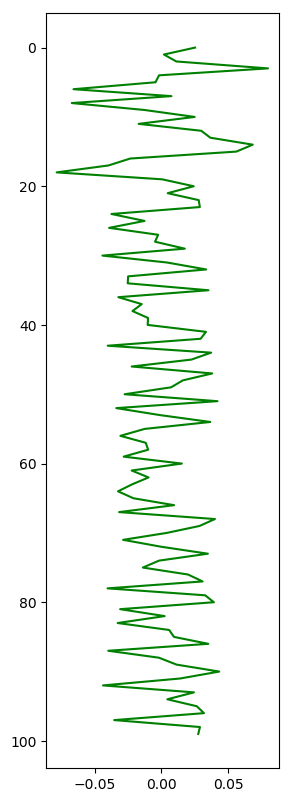

In [120]:
plt.figure(figsize=(3, 10), dpi = 100)
plt.gca().invert_yaxis()
plt.plot(dat[-1],y, c='green')